In [159]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve
from sklearn.feature_selection import f_classif
from sklearn import preprocessing as pp
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

import shap

import warnings
warnings.filterwarnings("ignore")

RAND = 42

In [160]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [161]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока 
# просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [163]:
# смотрим процент пропусков по признаку education
df.education.isna().sum() / df.shape[0]*100

0.4339615789664814

In [164]:
# заполняем пропуски в education модой
ed_mode = df.education.mode()[0]
df.education = df.education.fillna(ed_mode)

In [165]:
# или так
# заполнили пропуски в признаке 'education' наиболее часто встречающимся значением
# top = df_task['education'].describe()['top']
# df['education'] = df['education'].fillna(top)

In [166]:
df.education.value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [167]:
df.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [168]:
# разделяем признаки по типу
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'region_rating','income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [169]:
# переводим в категориальный тип признаки, где классы назначены по условию (мы не знаем принцип присвоения) 
df[cat_cols] = df[cat_cols].astype(object)

In [170]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [171]:
# сразу обработаем бинарные признаки для использования в EDA
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

label_encoder = pp.LabelEncoder()

for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


### EDA

### Гипотезы:

1) Возраст "хороших" заемщиков больше, по сравнению с "плохими" (распределения возраста в зависимости от флага дефолта смещено в большую сторону при default=0)
2) Уровень образования зависит от возраста, что влияет и на возврат кредита, также люди с высшим образованием чаще являются "хорошими" заемщиками
3) При good_work = 0 увеличивается риск невозврата кредита (флаг дефолта)
4) Доход "хороших" заемщиков больше, по сравнению с "плохими" (распределения дохода в зависимости от флага дефолта смещено в большую сторону при default=0)
5) score_bki напрямую взаимосвязан с default, чем он меньше, тем выше вероятность клиента выплатить кредит банку
6) Изучим как region_rating связан с default

### Целевая переменная - default

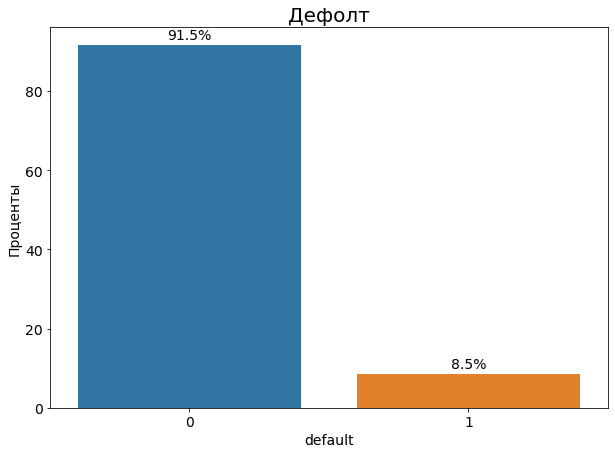

In [172]:
# нормирование на размер датасета
norm_target = (df
               .default
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(10, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Дефолт', fontsize=20)

plt.xlabel('default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Гипотеза 1

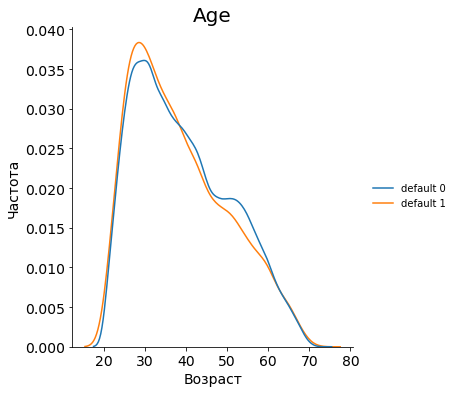

In [173]:
# исследуем признак AGE
sns.displot(
    {
        "default 0": df[df.default == 0].age,
        "default 1": df[df.default == 1].age
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('Age', fontsize=20)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [174]:
df.groupby('default')['age'].median()

default
0    37.0
1    36.0
Name: age, dtype: float64

In [175]:
df.groupby('default')['age'].mean()

default
0    39.316742
1    38.525395
Name: age, dtype: float64

In [176]:
df.groupby('default')['age'].apply(lambda x: x.value_counts().index[0]).reset_index()

,default,age
0,0,31
1,1,26


### ВЫВОД
Есть небольшие различия по возрасту в разрезе default, гипотеза подтвердилась: кредиты не возвращают более молодые заемщики. После 40 лет кривая "хороших" заемщиков смещается вправо, что говорит о надежности заемщиков 40+ лет.

### Гипотеза 2

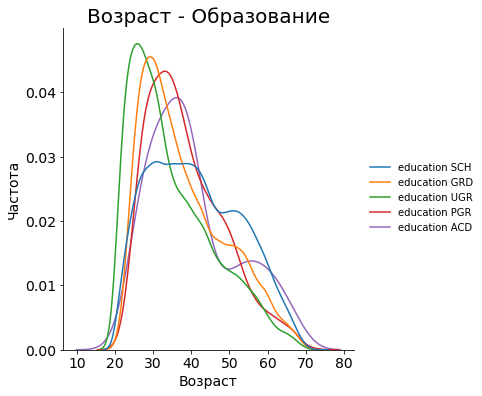

In [177]:
# исследуем признак EDUCATION
sns.displot(
    {
        "education SCH": df[df.education == 'SCH'].age,
        "education GRD": df[df.education == 'GRD'].age,
        "education UGR": df[df.education == 'UGR'].age,
        "education PGR": df[df.education == 'PGR'].age,
        "education ACD": df[df.education == 'ACD'].age,
    },
    kind="kde",
    common_norm=False
)

plt.title('Возраст - Образование', fontsize=20)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

SCH - school, основное школьное образование (9 кл)

GRD - graduate, среднее школьное образование (10-11 кл)

UGR - undergraduate, обучение в университете (2-4 года) до степени бакалавр

PGR - posgraduate, дополнительное обучение в университете (+ 2 года) до степени магистр

ACD - академическое (кандидатнаук/доктор)

Видно, что более высокое образование клиенты получают в более зрелом возрасте, а значит подтверждается гипотеза, что более высокий уровень образования снижает риск дефолта.
Отрицательный эксцесс SCH означает, что в данных наблюдается меньше выбросов, чем в нормальном распределении. У SCH самый большой разброс в гарницах ящика показателей по возрасту.

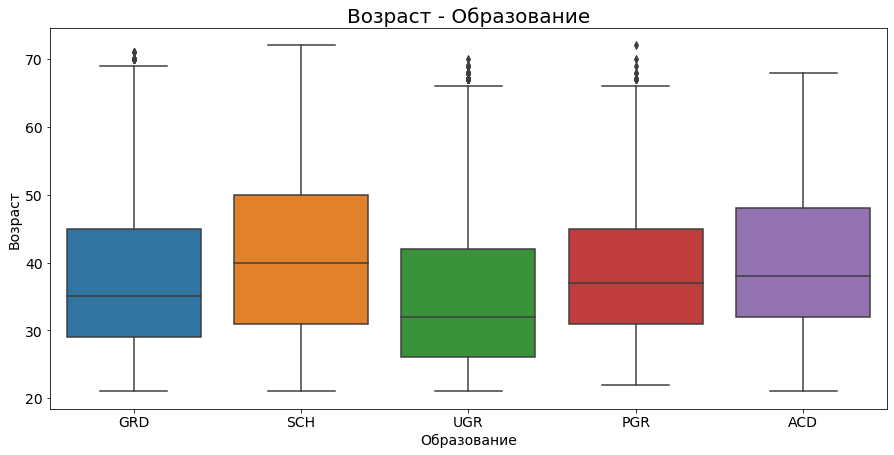

In [178]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', data=df)

plt.title('Возраст - Образование', fontsize=20)
plt.ylabel('Возраст', fontsize=14)
plt.xlabel('Образование', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Самые молодые - UGR, есть преположение, что в большей степени они будут являться "плохими" заемщиками.

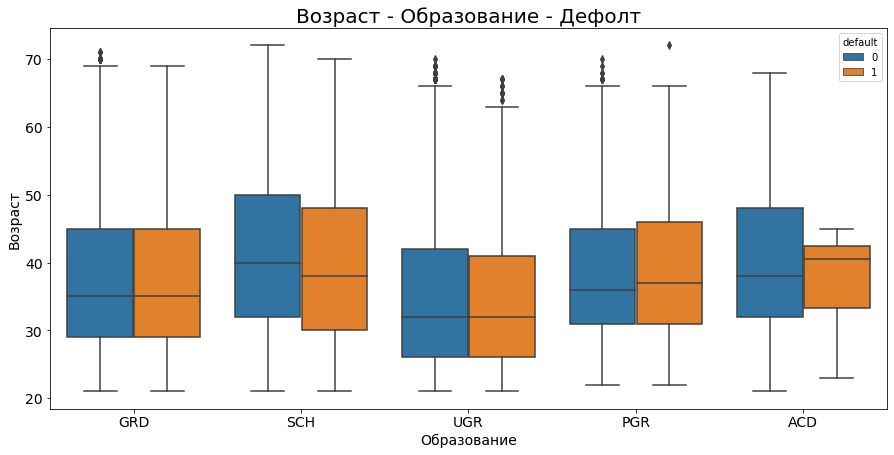

In [179]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', hue='default', data=df)

plt.title('Возраст - Образование - Дефолт', fontsize=20)
plt.ylabel('Возраст', fontsize=14)
plt.xlabel('Образование', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Интересно то, что если мы берем уровень образования PGR и ACD, то среднее значение возраста у "плохих" заемщиков выше, чем у "хороших", но разброс значений "хороших" заемщиков существенно больше (ACD). Возможно, если мы берем какой то предел возраст, например, от 30 до 50 лет, то внутри этой группы данный показатель не сильно будет влиять риск дефолта.

In [180]:
df.education.value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [181]:
df.groupby('education')['age'].median().sort_values(ascending=False)

education
SCH    40.0
ACD    38.0
PGR    37.0
GRD    35.0
UGR    32.0
Name: age, dtype: float64

Группа SCH является самой многочисленной и в ней самый старший средний возраст. Очень вероятно, что данный параметр окажет сильное влияние на модель.

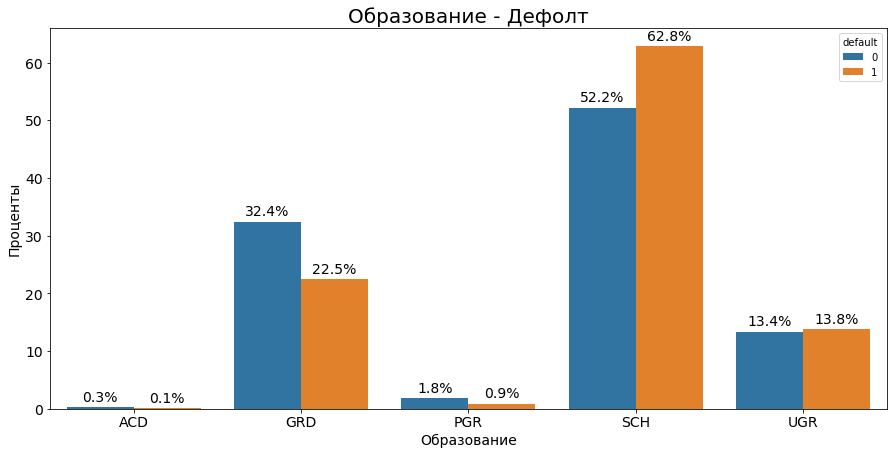

In [182]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['education']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('education'))

ax = sns.barplot(x="education", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Образование - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Образование', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Класс GRD и SCH взаимообратны по показателю дефолтных заемщиков

### Вывод
Возраст связан с уровнем образования.
Среди заемщиков больше всего людей с неполным средним образованием (SCH), и по данной группе в целом высокий риск дефолта. Но при этом средний возраст хороших заемщиков выше, чем средний возраст плохих, что подтверждает нашу Гипотезу 1.
Группы ACD, PGR умеренно надежны, группа GRD является самой "надежной". Группа UGR является самой "молодой" (median age = 32), по Гипотезе 1 мы предположили, что они будут самыми "плохими" заемщиками. Гипотеза 2 отчасти подтвердила этот вывод, показав риск дефолта почти 50/50.

### Гипотеза 3

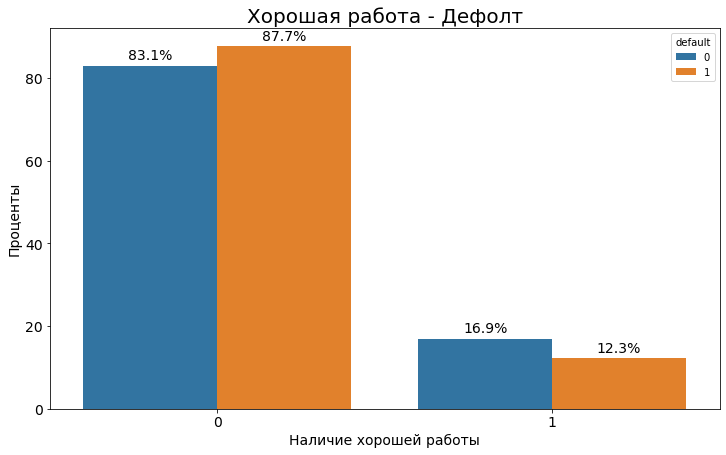

In [183]:
# изучаем признак good_work
plt.figure(figsize=(12, 7))

educ_def = (df.groupby(['default'])['good_work']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('good_work'))

ax = sns.barplot(x="good_work", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Хорошая работа - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Наличие хорошей работы', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Вывод
Гипотеза 3 подтверждается, заемщики с good_work=0 показали себя с худшей стороны в разрезе дефолта.

### Гипотеза 4

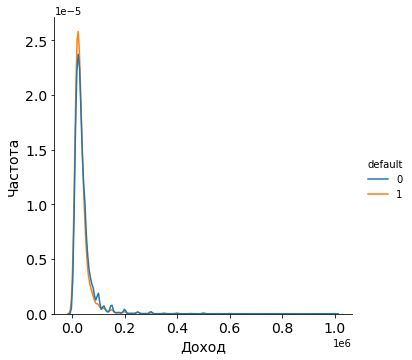

In [184]:
# рассматриваем признак INCOME
sns.displot(df, x='income', hue='default', kind="kde", common_norm=False)

plt.xlabel('Доход', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Признак имеет не нормальное распределение

In [185]:
df.groupby('default')['income'].mean()

default
0    41452.022436
1    36288.113316
Name: income, dtype: float64

In [186]:
df.groupby('default')['income'].median()

default
0    30000.0
1    28000.0
Name: income, dtype: float64

### Вывод
Так как на графике сложно увидеть зависимость, то смотрим на средние (mean/median) и видим, что уровень дохода влияет на риск дефолта. Чем выше доход, тем меньше риск дефолта. Этот признак будет иметь значительное влияние на модель.
Необходима нормализация данных в признаке.

In [187]:
# для нормализации распределения используем логарифмирование
# данный метод применяем на копии основного датасета (проводим эксперимент)
df_income = df.copy()
df_income.income = np.log(df.income+1)

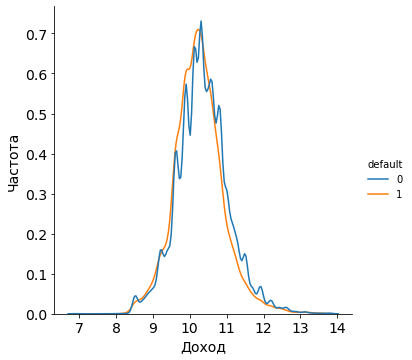

In [240]:
sns.displot(df_income, x='income', hue='default', kind="kde", common_norm=False)

plt.xlabel('Доход', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Признак приобрел нормальное распределение после метода логарифмирования. Можно применять на основном датасете.

### Гипотеза 5

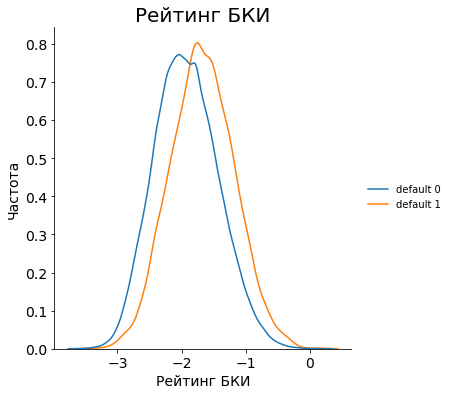

In [189]:
# исследуем признак score_bki
sns.displot(
    {
        "default 0": df[df.default == 0].score_bki,
        "default 1": df[df.default == 1].score_bki
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('Рейтинг БКИ', fontsize=20)
plt.xlabel('Рейтинг БКИ', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Вывод
Графики score+bki и default имеют практически идеальное смещение, значит признак score_bki сильно связан с целевой переменной default.

### Гипотеза 6

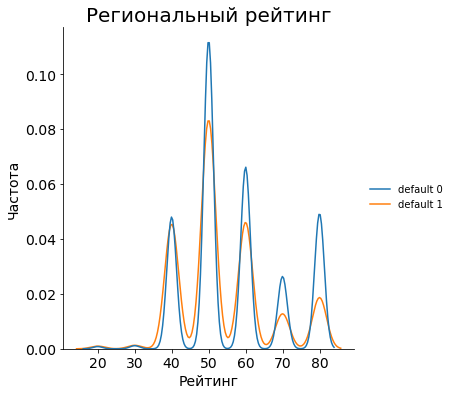

In [190]:
# исследуем признак region_rating
sns.displot(
    {
        "default 0": df[df.default == 0].region_rating,
        "default 1": df[df.default == 1].region_rating
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('Региональный рейтинг', fontsize=20)
plt.xlabel('Рейтинг', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

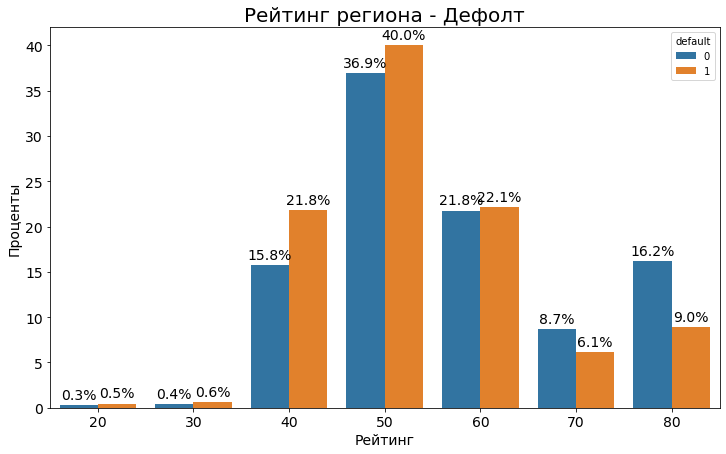

In [191]:
plt.figure(figsize=(12, 7))

region_def = (df.groupby(['default'])['region_rating']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('region_rating'))

ax = sns.barplot(x="region_rating", y="percentage", hue="default", data=region_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Рейтинг региона - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Рейтинг', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Вывод
Существенная разница в сторону "плохих" кредитов в регионах с рейтингом 40-60 баллов. Относительно небольшая разница в качестве кредитов в регионах с рейтингом 60-70 баллов. И только. врегионах с рейтингом 80 баллов можно видеть приемлемое количество "хороших" кредитов.

### Feature Enginearing

In [192]:
# месяц
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')
df['month'] = df['app_date'].dt.month.astype(object)

df.drop(['app_date'],  axis=1, inplace=True)

In [193]:
# cредний score bki с учетом образования

mean_bki_edu = df.groupby('education')['score_bki'].median().to_dict()
df['mean_bki_edu'] = df['education'].map(mean_bki_edu)

In [194]:
# cредний score bki с учетом дохода

mean_bki_inc = df.groupby('income')['score_bki'].median().to_dict()
df['mean_bki_inc'] = df['income'].map(mean_bki_inc)

In [195]:
# cредний доход с учетом рейтинга региона

mean_inc_reg = df.groupby('region_rating')['income'].median().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_inc_reg)

### Pre-processing

In [196]:
df.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default', 'month',
       'mean_bki_edu', 'mean_bki_inc', 'mean_income_region'],
      dtype='object')

In [201]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'region_rating', 'income']

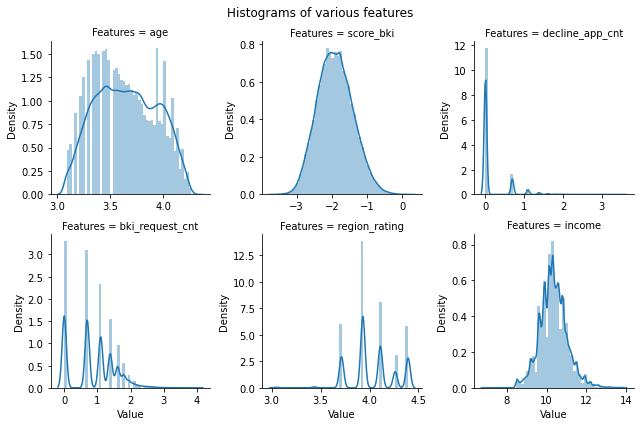

In [202]:
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

Данные графики построены на исходном датасете (df)

In [203]:
# нормализуем числовые признаки в исходном датасете методом логарифмирования
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'region_rating', 'income']:
    df[i] = np.log(df[i]+1)

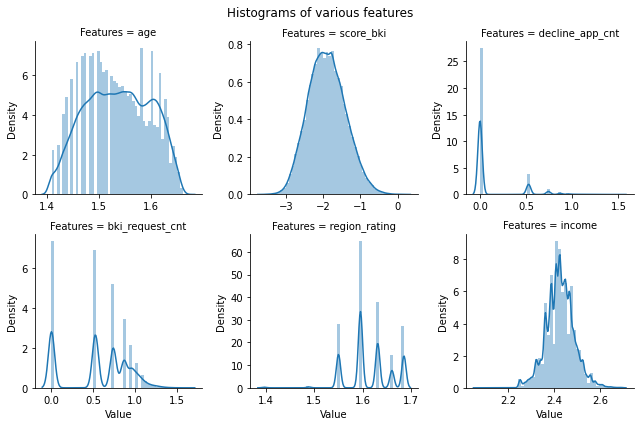

In [204]:
# проверяем результат логарифмирования признаков
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

Данные немного выровнялись

На даный момент единственное наше вмешательство в исходный датасет - логарифмирование числовых признаков

In [205]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,sample,default,month,mean_bki_edu,mean_bki_inc,mean_income_region
0,74835,GRD,1,1.481877,1,1,0.000000,0,-2.271884,0.869742,...,2.469776,1,4,0,0,0,3,-1.938995,-1.936201,25000.0
1,17527,SCH,0,1.545194,0,0,1.026672,0,-1.504999,0.741276,...,2.253121,4,3,0,0,0,1,-1.920823,-1.998833,25000.0
2,75683,UGR,1,1.595709,1,1,0.000000,0,-1.691339,0.526589,...,2.425598,1,3,1,0,0,3,-1.865290,-1.940217,25000.0
3,26883,SCH,1,1.618011,0,0,0.000000,0,-2.374182,0.526589,...,2.374071,1,3,0,0,0,2,-1.920823,-1.958425,25000.0
4,28862,GRD,0,1.539779,0,0,0.000000,0,-2.487502,0.000000,...,2.541228,1,3,0,0,0,2,-1.938995,-1.947818,48000.0


In [206]:
# обрабатываем категориальные признаки с оцифровкой класса
cat_cols_1 = ['first_time', 'sna', 'month']

In [207]:
label_encoder = pp.LabelEncoder()

for col in cat_cols_1:
    df[col] = label_encoder.fit_transform(df[col])
    
# убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,sample,default,month,mean_bki_edu,mean_bki_inc,mean_income_region
0,74835,GRD,1,1.481877,1,1,0.000000,0,-2.271884,0.869742,...,2.469776,0,3,0,0,0,2,-1.938995,-1.936201,25000.0
1,17527,SCH,0,1.545194,0,0,1.026672,0,-1.504999,0.741276,...,2.253121,3,2,0,0,0,0,-1.920823,-1.998833,25000.0
2,75683,UGR,1,1.595709,1,1,0.000000,0,-1.691339,0.526589,...,2.425598,0,2,1,0,0,2,-1.865290,-1.940217,25000.0
3,26883,SCH,1,1.618011,0,0,0.000000,0,-2.374182,0.526589,...,2.374071,0,2,0,0,0,1,-1.920823,-1.958425,25000.0
4,28862,GRD,0,1.539779,0,0,0.000000,0,-2.487502,0.000000,...,2.541228,0,2,0,0,0,1,-1.938995,-1.947818,48000.0


In [208]:
# обрабатываем категориальные признаки через get_dummies
cat_cols = ['education', 'work_address', 'home_address']

df = pd.get_dummies(df, columns=cat_cols,
                          drop_first=False).drop('client_id', axis=1)
df.head()

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,...,education_GRD,education_PGR,education_SCH,education_UGR,work_address_1,work_address_2,work_address_3,home_address_1,home_address_2,home_address_3
0,1,1.481877,1,1,0.000000,0,-2.271884,0.869742,1.595709,2.469776,...,1,0,0,0,0,1,0,1,0,0
1,0,1.545194,0,0,1.026672,0,-1.504999,0.741276,1.595709,2.253121,...,0,0,1,0,0,1,0,1,0,0
2,1,1.595709,1,1,0.000000,0,-1.691339,0.526589,1.595709,2.425598,...,0,0,0,1,0,1,0,1,0,0
3,1,1.618011,0,0,0.000000,0,-2.374182,0.526589,1.550446,2.374071,...,0,0,1,0,0,1,0,1,0,0
4,0,1.539779,0,0,0.000000,0,-2.487502,0.000000,1.685370,2.541228,...,1,0,0,0,0,0,1,0,1,0


In [209]:
# проверяем датасет на наличие пропусков и тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sex                 110148 non-null  int64  
 1   age                 110148 non-null  float64
 2   car                 110148 non-null  int64  
 3   car_type            110148 non-null  int64  
 4   decline_app_cnt     110148 non-null  float64
 5   good_work           110148 non-null  int64  
 6   score_bki           110148 non-null  float64
 7   bki_request_cnt     110148 non-null  float64
 8   region_rating       110148 non-null  float64
 9   income              110148 non-null  float64
 10  sna                 110148 non-null  int64  
 11  first_time          110148 non-null  int64  
 12  foreign_passport    110148 non-null  int64  
 13  sample              110148 non-null  int64  
 14  default             110148 non-null  int64  
 15  month               110148 non-nul

In [210]:
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default', 'month',
       'mean_bki_edu', 'mean_bki_inc', 'mean_income_region', 'education_ACD',
       'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
       'work_address_1', 'work_address_2', 'work_address_3', 'home_address_1',
       'home_address_2', 'home_address_3'],
      dtype='object')

In [211]:
df.sample()

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,...,education_GRD,education_PGR,education_SCH,education_UGR,work_address_1,work_address_2,work_address_3,home_address_1,home_address_2,home_address_3
43971,1,1.457646,1,0,0.0,0,-2.343537,0.0,1.595709,2.460822,...,0,0,1,0,0,0,1,0,1,0


### Корреляция

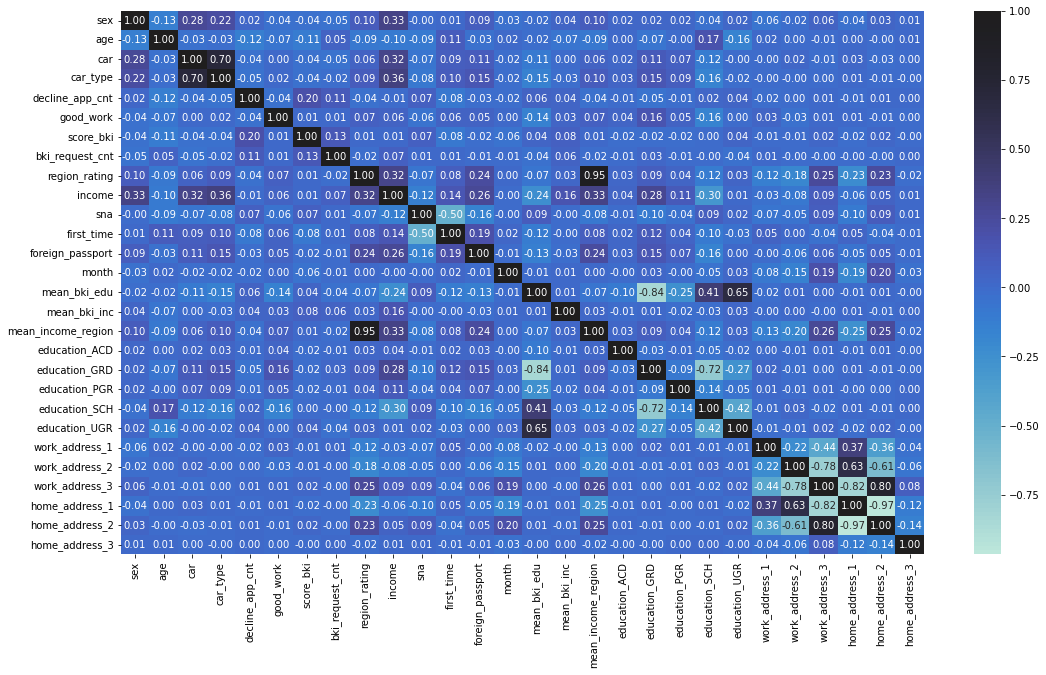

In [212]:
# смотрим все получившиеся признаки (кроме целевого)
final_cols = ['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'sna',
       'first_time', 'foreign_passport', 'month',
       'mean_bki_edu', 'mean_bki_inc', 'mean_income_region', 'education_ACD',
       'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
       'work_address_1', 'work_address_2', 'work_address_3', 'home_address_1',
       'home_address_2', 'home_address_3']

plt.figure(figsize=(18, 10))

sns.heatmap(df[final_cols].corr(method='spearman'), annot=True, fmt=".2f", center=1);

<AxesSubplot:>

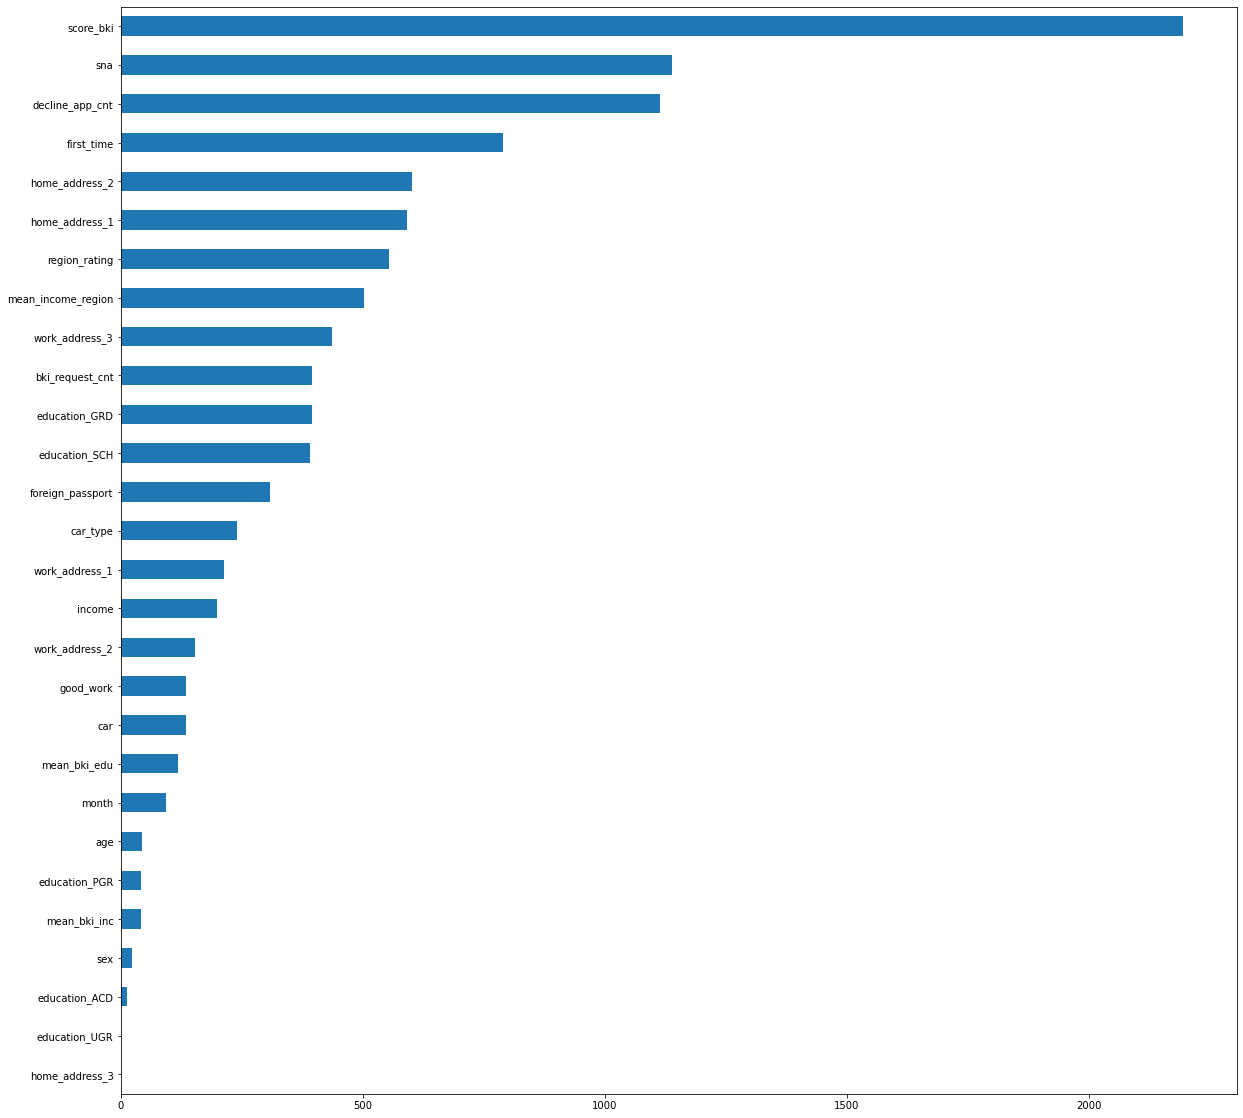

In [213]:
# проводим анализ значимости признаков (метод ANOVA)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20,20)

imp_num = pd.Series(f_classif(df[final_cols], df['default'])[0], index = final_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Вывод
С учетом взаимокоррелируемости признаков и их влияния на целевой признак, есть предположение избавиться от признаков: 
* car, 
* mean_income_region (созданный нами признак не пригодился), 
* work_address_1/2/3 (сильно скоррелированы с home_address, но при этом мало оказывают влюяние на целевую)


In [214]:
# создаем финальный датасет для последующего моделирования
df = df.drop(columns=['car', 'mean_income_region', 'work_address_1', 'work_address_2', 'work_address_3'])

In [215]:
df.head()

,sex,age,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,...,mean_bki_edu,mean_bki_inc,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,home_address_1,home_address_2,home_address_3
0,1,1.481877,1,0.000000,0,-2.271884,0.869742,1.595709,2.469776,0,...,-1.938995,-1.936201,0,1,0,0,0,1,0,0
1,0,1.545194,0,1.026672,0,-1.504999,0.741276,1.595709,2.253121,3,...,-1.920823,-1.998833,0,0,0,1,0,1,0,0
2,1,1.595709,1,0.000000,0,-1.691339,0.526589,1.595709,2.425598,0,...,-1.865290,-1.940217,0,0,0,0,1,1,0,0
3,1,1.618011,0,0.000000,0,-2.374182,0.526589,1.550446,2.374071,0,...,-1.920823,-1.958425,0,0,0,1,0,1,0,0
4,0,1.539779,0,0.000000,0,-2.487502,0.000000,1.685370,2.541228,0,...,-1.938995,-1.947818,0,1,0,0,0,0,1,0


### Моделирование

In [4]:
# выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample', 'default'], axis=1)

X = train_data.drop(['default'], axis=1)
y = train_data['default'].values  # наш таргет

NameError: name 'df' is not defined

In [5]:
# делим датасет на обучающий и валидационный
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RAND)

NameError: name 'train_test_split' is not defined

In [243]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 23), (14760, 23), (59039,), (14760,))

In [244]:
# проводим стандартизацию данных
scaler = StandardScaler()

In [245]:
# для обучаемой среды
X_train_ss = scaler.fit_transform(X_train)

In [246]:
# для валидационной среды
X_test_ss = scaler.transform(X_test)

In [247]:
# проводим обучение модели
lr = LogisticRegression(class_weight = 'balanced', solver='liblinear', max_iter=1000)
lr.fit(X_train_ss, y_train)

y_pred = lr.predict(X_test_ss)
y_score = lr.predict_proba(X_test_ss)[:,1]

In [248]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.7415913204473343
precision: 0.22665690223361407
recall: 0.6776135741652983
f1: 0.3396899437508574
logloss: 11.262771564244597


In [224]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics['Baseline_LR'] = [roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]

In [225]:
metrics

,Baseline_LR
roc-auc,0.741591
precision,0.226657
recall,0.677614
f1,0.339690
logloss,11.262772


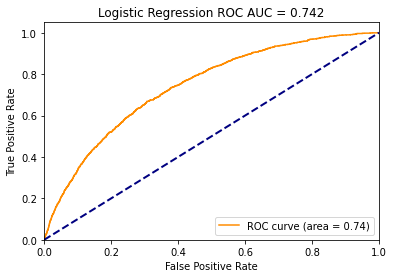

In [226]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [227]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_test,y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



In [277]:
random_seed = 42
C = np.logspace(-2, 1, 10)
iter_ = 100
epsilon_stop = 1e-3
 
param_grid = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'lbfgs'],
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     #'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'],
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [3]:
lr = LogisticRegression(class_weight = 'balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True)
grid_cv = GridSearchCV(lr, param_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

NameError: name 'LogisticRegression' is not defined

In [279]:
#parameters_grid = {
#    'penalty': ['l1', 'l2', 'elasticnet'],
#    'C': np.linspace(1, 1000, num=5),
#    'solver': ['sag', 'saga', 'lbfgs'],
#    'l1_ratio': [0.25, 0.5, 0.75],
#    'max_iter': np.arange(100, 500, 100)
#}

#lr = LogisticRegression(class_weight='balanced')
#cv = StratifiedKFold(n_splits=3, shuffle=True)
#grid_cv = GridSearchCV(lr, parameters_grid,
#                       scoring='roc_auc', cv=cv, verbose=2)

In [280]:
# производим обучение по сетке
grid_cv.fit(X_train_ss, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001; total time=   0.3s
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001; total time=   0.3s
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001; total time=   0.3s
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001; total time=   0.4s
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001; total time=   0.3s
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=lbfgs, tol=0.001; total time=   0.0s
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=lbfgs, tol=0.001; total time=   0.0s
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=lbfgs, tol=0.001; total time=   0.0s
[CV] END C=0.01, max_iter=100, multi_class=auto, penalty=l1, solver=lbfgs, to

KeyboardInterrupt: 

In [281]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [1]:
best_params = {'C': 0.01, 
               'l1_ratio': 0.25,
               'max_iter': 100, 
               'penalty': 'l1',
               'multi_class': 'auto',
               'solver': 'liblinear',
               'tol': 0.001}

In [2]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train_ss, y_train)

y_pred_gr = lr_gr.predict(X_test_ss)
y_score_gr = lr_gr.predict_proba(X_test_ss)[:,1]

NameError: name 'LogisticRegression' is not defined

In [273]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7415844220249951
precision: 0.2259475218658892
recall: 0.6787082649151615
f1: 0.3390293916609706
logloss: 11.314253425425244


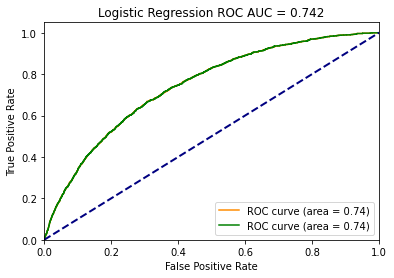

In [274]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_score_gr)

roc_auc_2 = auc(fpr_2, tpr_2)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_2, tpr_2, color='green', label='ROC curve (area = %0.2f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [276]:
metrics['Grid_LR'] = [roc_auc_score(y_test, y_score_gr),
                      precision_score(y_test, y_pred_gr),
                      recall_score(y_test, y_pred_gr),
                      f1_score(y_test, y_pred_gr),
                      log_loss(y_test, y_pred_gr)]

In [262]:
metrics

,Baseline_LR,Grid_LR
roc-auc,0.741591,0.741585
precision,0.226657,0.225906
recall,0.677614,0.678708
f1,0.339690,0.338983
logloss,11.262772,11.316594


### Анализ данных

In [234]:
explainer = shap.LinearExplainer(lr_gr, X_train, feature_dependence="independent")
shap_values = explainer(X_test)

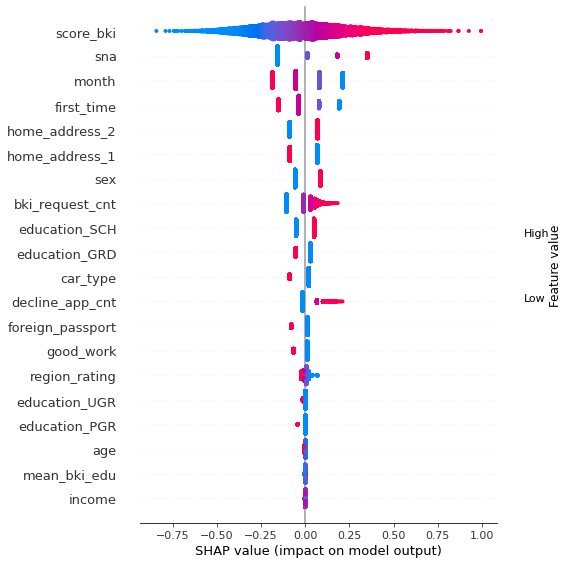

In [235]:
shap.summary_plot(shap_values, X_test)

In [239]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = X_train.columns
feature_imp['imp'] = lr_gr.coef_[0]
feature_imp = feature_imp.sort_values(by='imp', ascending=False)
feature_imp

,feature,imp
5,score_bki,0.484120
6,bki_request_cnt,0.183989
9,sna,0.169587
21,home_address_2,0.158540
3,decline_app_cnt,0.158303
0,sex,0.144356
18,education_SCH,0.101689
13,mean_bki_edu,0.043203
14,mean_bki_inc,0.004829
22,home_address_3,-0.010278
